# Explaining Logic Programs under the SM-Semantics

In [1]:
from typing import Sequence, Optional, Iterator

import clingo
import clingraph.clingo_utils
from clingraph import Factbase, compute_graphs

In [2]:
def solve(programs,
          ctl: Optional[clingo.Control] = None,
          parts=(('base', ()),),
          context=None,
          report=False,
          report_models=True,
          report_result=True,
          symbol_sep=' ',
          model_sep='\n'
          ) -> Iterator[Sequence[clingo.Symbol]]:
    if ctl is None:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, context=context)
    with ctl.solve(yield_=True) as solve_handle:
        models = 0
        for model in solve_handle:
            symbols = sorted(model.symbols(shown=True))
            if report and report_models:
                print("Answer {}:".format(model.number), end=' ')
                print("{",
                      symbol_sep.join(map(str, symbols)), "}", sep=symbol_sep, end=model_sep)
            models += 1
            yield symbols
        if report and report_result:
            solve_result = solve_handle.get()
            print(solve_result, end='')
            if solve_result.satisfiable:
                print(" {}{}".format(models, '' if solve_result.exhausted else '+'))
            else:
                print()

def draw_graph(programs,
          ctl: Optional[clingo.Control] = None,
          parts=(('base', ()),)):
    fb = Factbase()
    if ctl is None:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, clingraph.clingo_utils.ClingraphContext())
    with ctl.solve(yield_=True) as solve_handle:
        for model in solve_handle:
            fb.add_model(model)
            break
    return compute_graphs(fb)

Given is the following logic program.

In [3]:
primal = """

a :- k, not b.
c :- a, b.
c :- k.
k :- e, not b.

e.

b :- not a.
f :- e, not k, not c.

"""

primal_answer_sets = tuple(solve([primal], report=True))

Answer 1: { b e f }
Answer 2: { a c e k }
SAT 2


It has two stable models (answer sets). However, it is not (immediately) apparent why an atom is in the answer set (and why another isn't).

To get these explanations we have to find a causal chain of statements (proof) which show how the stable model was derived. Logic programs are a certain type of directed graph, from which we can extract this proof as a tree structure.

In [4]:
graph_encoding = """

node(U) :- edge((U,V)).
node(V) :- edge((U,V)).

attr(node, L, label, L) :- pos_literal(L).
attr(node, N, label, @concat("not ", P)) :- neg_literal(N), pos_neg(P,N).

attr(node, L, style, filled) :- neg_literal(L).
attr(node, L, fontcolor, white) :- neg_literal(L).
attr(node, L, color, black) :- neg_literal(L).

node(Rule) :- rule(Rule).

attr(edge, E, dir, forward) :- edge(E).
attr(node, Rule, shape, box) :- rule(Rule).

"""

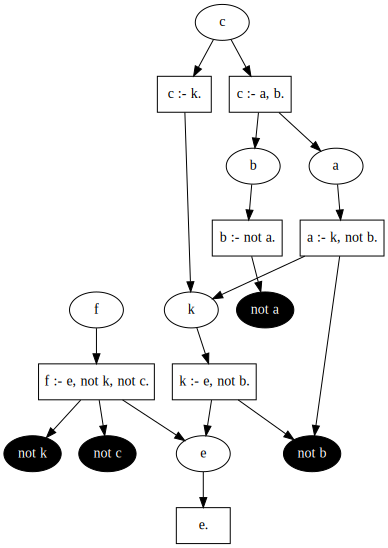

In [5]:
primal_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

rule(r1).
attr(node, r1, label, "a :- k, not b.").
edge((a, r1)).
edge((r1, k)).
edge((r1, -b)).

rule(r2).
attr(node, r2, label, "c :- a, b.").
edge((c, r2)).
edge((r2, a)).
edge((r2, b)).

rule(r3).
attr(node, r3, label, "c :- k.").
edge((c, r3)).
edge((r3, k)).

rule(r4).
attr(node, r4, label, "k :- e, not b.").
edge((k, r4)).
edge((r4, e)).
edge((r4, -b)).

rule(r5).
attr(node, r5, label, "e.").
edge((e, r5)).

rule(r6).
attr(node, r6, label, "b :- not a.").
edge((b, r6)).
edge((r6, -a)).

rule(r7).
attr(node, r7, label, "f :- e, not k, not c.").
edge((f, r7)).
edge((r7, e)).
edge((r7, -k)).
edge((r7, -c)).

"""

primal_graph = draw_graph([primal_graph_str, graph_encoding])['default']
primal_graph

A logic program graph has two types of nodes. Nodes that describe the literals (round) and nodes that describe the rules. Each literal that is in the head of a rule points to that rule. Each rule points to its literals in the body. If all rule heads are positive we call this graph a *primal* graph.

As the name suggests we also are able to derive a *dual* from the primal. The dual takes each rule and groups them by heads
\begin{aligned}
p \leftarrow B_1\\
p \leftarrow B_2\\
\vdots \\
p \leftarrow B_n
\end{aligned}
Then the dual rule is:
\begin{equation}
\text{not}~p \leftarrow \text{not}~B_1, \text{not}~B_2, \ldots, \text{not}~B_n.
\end{equation}

If a literal does not have any heads it is a negative fact.
\begin{equation}
\text{not}~p.
\end{equation}

Facts do not have a dual equivalent (as their negative can never be derived).

In [6]:
dual = """

not a :- not k.
not a :- b.
not c :- not __c_1, not k.
not __c_1 :- not a.
not __c_1 :- not b.
not k :- not e.
not k :- b.

not b :- a.
not f :- not e.
not f :- k.
not f :- c.

"""

dual_answer_sets = tuple(solve([dual], report=True))

Answer 1: {  }
SAT 1


<block>:3:5-6: info: atom does not occur in any rule head:
  a

<block>:3:14-15: info: atom does not occur in any rule head:
  k

<block>:4:5-6: info: atom does not occur in any rule head:
  a

<block>:4:10-11: info: atom does not occur in any rule head:
  b

<block>:5:5-6: info: atom does not occur in any rule head:
  c

<block>:5:14-19: info: atom does not occur in any rule head:
  __c_1

<block>:5:25-26: info: atom does not occur in any rule head:
  k

<block>:6:5-10: info: atom does not occur in any rule head:
  __c_1

<block>:6:18-19: info: atom does not occur in any rule head:
  a

<block>:7:5-10: info: atom does not occur in any rule head:
  __c_1

<block>:7:18-19: info: atom does not occur in any rule head:
  b

<block>:8:5-6: info: atom does not occur in any rule head:
  k

<block>:8:14-15: info: atom does not occur in any rule head:
  e

<block>:9:5-6: info: atom does not occur in any rule head:
  k

<block>:9:10-11: info: atom does not occur in any rule head:
  b

<block>:11

With the same graph encoding we can draw the dual graph.

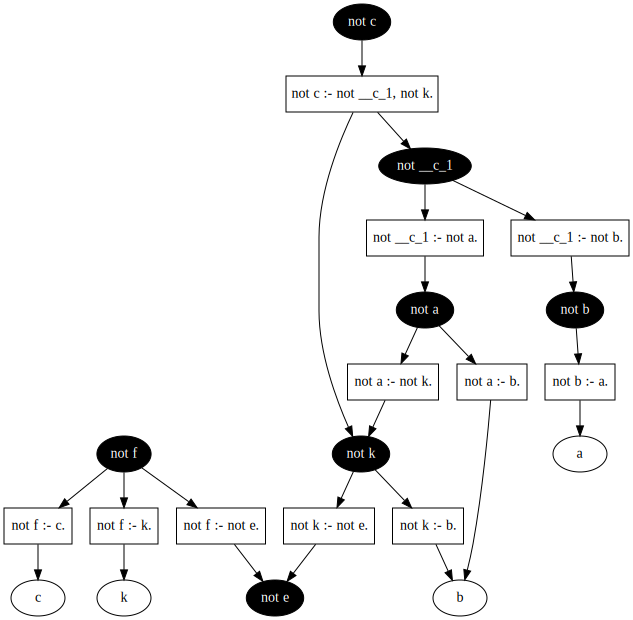

In [7]:
dual_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

neg_literal(-__c_1).
pos_neg(__c_1, -__c_1).

rule(d1).
attr(node, d1, label, "not a :- not k.").
edge((-a, d1)).
edge((d1, -k)).

rule(d2).
attr(node, d2, label, "not a :- b.").
edge((-a, d2)).
edge((d2, b)).

rule(d3).
attr(node, d3, label, "not c :- not __c_1, not k.").
edge((-c, d3)).
edge((d3, -__c_1)).
edge((d3, -k)).

rule(d4).
attr(node, d4, label, "not __c_1 :- not a.").
edge((-__c_1, d4)).
edge((d4, -a)).

rule(d5).
attr(node, d5, label, "not __c_1 :- not b.").
edge((-__c_1, d5)).
edge((d5, -b)).

rule(d6).
attr(node, d6, label, "not k :- not e.").
edge((-k, d6)).
edge((d6, -e)).

rule(d7).
attr(node, d7, label, "not k :- b.").
edge((-k, d7)).
edge((d7, b)).

rule(d8).
attr(node, d8, label, "not b :- a.").
edge((-b, d8)).
edge((d8, a)).

rule(d9).
attr(node, d9, label, "not f :- not e.").
edge((-f, d9)).
edge((d9, -e)).

rule(d10).
attr(node, d10, label, "not f :- k.").
edge((-f, d10)).
edge((d10, k)).

rule(d11).
attr(node, d11, label, "not f :- c.").
edge((-f, d11)).
edge((d11, c)).


"""

dual_graph = draw_graph([dual_graph_str, graph_encoding])['default']
dual_graph

If we include the _primal_ and the _dual_ rules we get the *complete* graph.

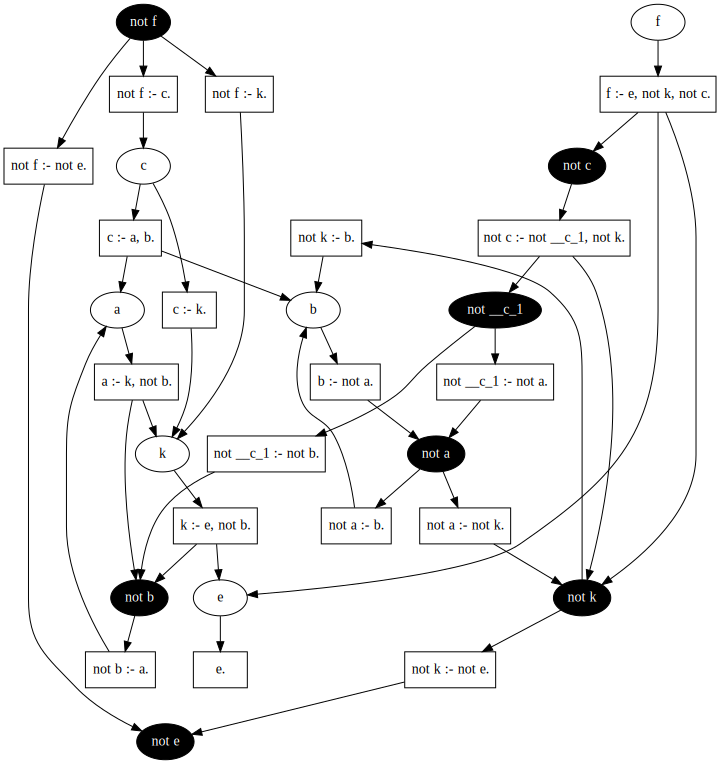

In [8]:
complete_graph = draw_graph([primal_graph_str, dual_graph_str, graph_encoding])['default']
complete_graph

This gives a more or less intuitive view into the structure of the program, however it is still not an explanation (proof) for an individual answer set.

To achieve the desired proof we pick an answer set (in this case $\{b, e, f\}$). Then we remove every rule which does not derive any of those literals. We call this the *normal form* with respect to an answer set. As the result is again a logic program (a subset of the original program), we can still draw it.

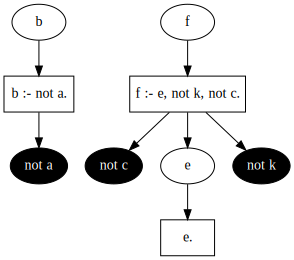

In [9]:
nf_primal_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

rule(r5).
attr(node, r5, label, "e.").
edge((e, r5)).

rule(r6).
attr(node, r6, label, "b :- not a.").
edge((b, r6)).
edge((r6, -a)).

rule(r7).
attr(node, r7, label, "f :- e, not k, not c.").
edge((f, r7)).
edge((r7, e)).
edge((r7, -k)).
edge((r7, -c)).

"""

nf_primal_graph = draw_graph([nf_primal_graph_str, graph_encoding])['default']
nf_primal_graph

In this case we drew the *primal normal form*. This explains why $\{b, e, f\}$ are in the answer set, however it does not explain why $\{k, c, a\}$ are not part of the answer set.

To derive the reasons for that we apply the *normal form* transformation with respect to the answer set to the _dual_ of the program. Notice how we remove all rules which derive the complement of the answer set.

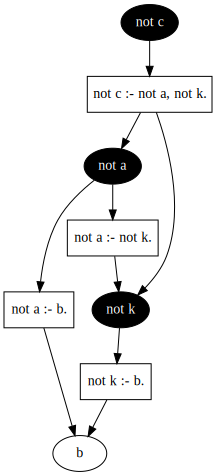

In [10]:
nf_dual_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

rule(d1).
attr(node, d1, label, "not a :- not k.").
edge((-a, d1)).
edge((d1, -k)).

rule(d2).
attr(node, d2, label, "not a :- b.").
edge((-a, d2)).
edge((d2, b)).

rule(d3).
attr(node, d3, label, "not c :- not a, not k.").
edge((-c, d3)).
edge((d3, -a)).
edge((d3, -k)).

rule(d7).
attr(node, d7, label, "not k :- b.").
edge((-k, d7)).
edge((d7, b)).


"""

nf_dual_graph = draw_graph([nf_dual_graph_str, graph_encoding])['default']
nf_dual_graph

This provides an interpretation on why $\{k, c, a\}$ are not in the answer set (with respect to the answer set).

Because we both *normal forms* are just logic programs again we can draw them together. We call this the *normal form* of the complete graph with respect to the answer set.

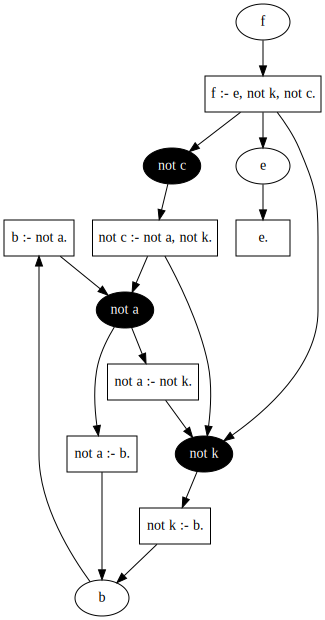

In [11]:
nf_graph = draw_graph([nf_primal_graph_str, nf_dual_graph_str, graph_encoding])['default']
nf_graph

We nearly derived our desired proof tree. A problem that remains is the negative cycle(s) $\text{not}~a \to b$ and $\text{not}~k \to b \to \text{not}~a$. If we have a negative cycle assume one of the negative literals to be false, in order to root the proof tree.

In the first case we assume $k$ to be false.

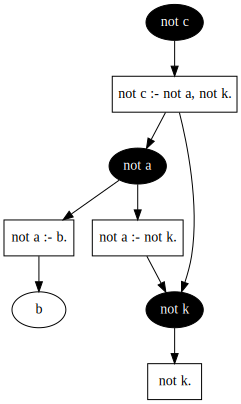

In [12]:
exp_1_dual_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

rule(d1).
attr(node, d1, label, "not a :- not k.").
edge((-a, d1)).
edge((d1, -k)).

rule(d2).
attr(node, d2, label, "not a :- b.").
edge((-a, d2)).
edge((d2, b)).

rule(d3).
attr(node, d3, label, "not c :- not a, not k.").
edge((-c, d3)).
edge((d3, -a)).
edge((d3, -k)).

rule(d7).
attr(node, d7, label, "not k.").
edge((-k, d7)).


"""

exp_1_dual_graph = draw_graph([exp_1_dual_graph_str, graph_encoding])['default']
exp_1_dual_graph

$\text{not}~k$ no longer needs a rule that derives it.

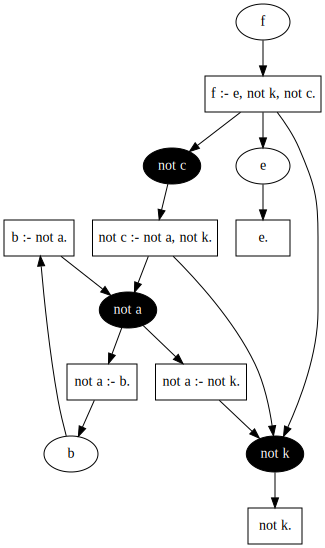

In [13]:
exp_1_graph = draw_graph(([exp_1_dual_graph_str, nf_primal_graph_str, graph_encoding]))['default']
exp_1_graph

Combining the original primal graph in normal form with respect to the answer set and this rooted dual graph in normal form yields an explanation graph.

We can also root $\text{not}~a$.

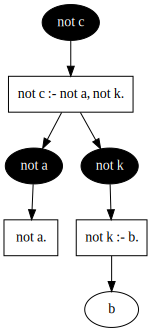

In [14]:
exp_2_dual_graph_str = """

pos_literal(a;b;c;e;f;k).
neg_literal(-a;-b;-c;-e;-f;-k).
pos_neg(a,-a;b,-b;c,-c;e,-e;f,-f;k,-k).

rule(d1).
attr(node, d1, label, "not a.").
edge((-a, d1)).

rule(d3).
attr(node, d3, label, "not c :- not a, not k.").
edge((-c, d3)).
edge((d3, -a)).
edge((d3, -k)).

rule(d7).
attr(node, d7, label, "not k :- b.").
edge((-k, d7)).
edge((d7, b)).


"""

exp_2_dual_graph = draw_graph([exp_2_dual_graph_str, graph_encoding])['default']
exp_2_dual_graph

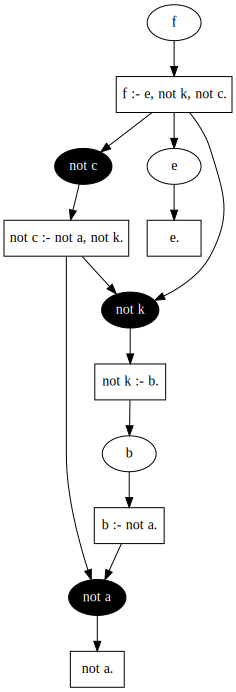

In [15]:
exp_2_graph = draw_graph([exp_2_dual_graph_str, nf_primal_graph_str, graph_encoding])['default']
exp_2_graph